In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, diags, eye
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot as plt
import pylab

plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (18.0, 12.0)

%matplotlib inline

In [2]:
#df = pd.read_csv("./data/facebook_combined.txt.gz", compression='infer', sep=" ")
df = pd.read_csv("./data/twitter_combined.txt.gz", compression='infer', sep=" ", header=None)

print(len(df))
df.head()

2420766


,0,1
0,214328887,34428380
1,17116707,28465635
2,380580781,18996905
3,221036078,153460275
4,107830991,17868918


In [3]:
df.columns = ["0", "1"]

In [4]:
nodes = list(set(df["0"]) | set(df["1"]))
nodes.sort()
nodes[:20]
nodes_to_idx = {n:i for i,n in enumerate(nodes)}

df_o = df
df = pd.DataFrame({"0": df["0"].apply(lambda x: nodes_to_idx[x]), 
                   "1": df["1"].apply(lambda x: nodes_to_idx[x])})
df.head()          

,0,1
0,64848,33444
1,15266,30189
2,76829,19302
3,65515,58679
4,52420,16766


In [5]:
df.describe()

,0,1
count,2.420766e+06,2.420766e+06
mean,3.863062e+04,3.579259e+04
std,2.424377e+04,2.372641e+04
min,0.000000e+00,0.000000e+00
25%,1.635800e+04,1.423600e+04
50%,3.852100e+04,3.366600e+04
75%,6.046100e+04,5.655900e+04
max,8.130500e+04,8.130500e+04


In [6]:
e = len(df)
v = max(np.max(np.unique(df["0"])), np.max(np.unique(df["1"]))) + 1
print(e,v)

2420766 81306


## Passage au Laplacien

In [7]:
facebook2 = csr_matrix((np.ones(e), (df['0'], df['1'])), shape=(v,v))
facebook2 = 1.0 * ((facebook2 + facebook2.T) !=0)

In [8]:
(facebook2 > 1)

<81306x81306 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>

In [9]:
%time deg = np.array(facebook2.sum(axis=0))[0]

print(deg.shape)
print((deg == 0).sum())

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 9.26 ms
(81306,)
0


In [10]:
L = diags(np.array(facebook2.sum(axis=0))[0]) - facebook2
L = L.astype(np.float32)
L

<81306x81306 sparse matrix of type '<class 'numpy.float32'>'
	with 2765898 stored elements in Compressed Sparse Row format>

In [11]:
from scipy.sparse.linalg import eigsh

In [12]:
import os.path
import pickle

n_clusters = int(L.shape[0]/40) 
neig = 2 + int(np.log2(n_clusters))

print(n_clusters, neig)

f_vec = "pkl/twitter_eigen_vec_%d.pkl" % neig
f_val = "pkl/twitter_eigen_val_%d.pkl" % neig

if os.path.isfile(f_vec) and os.path.isfile(f_val):
    
    with open(f_vec, "rb") as f:
        eigvec = pickle.load(f)
    with open(f_val, "rb") as f:
        eigval = pickle.load(f)
    
else:
    %time eigval, eigvec = eigsh(L, neig, which='SM', tol=1e-3)
    with open("pkl/twitter_eigen_vec.pkl", "wb") as f:
        pickle.dump(eigvec, f)
    with open("pkl/twitter_eigen_val.pkl", "wb") as f:
        pickle.dump(eigval, f)
# 15 min for 14 et 20...
# 21 min for 12

#%time eigval, eigvec = eigsh(L, neig, which='LM', tol=1e-2, sigma=0)
# very very long! => SystemError: gstrf was called with invalid arguments

eigval

2032 12
CPU times: user 14min 37s, sys: 14.8 s, total: 14min 51s
Wall time: 3min 43s


array([  2.47494827e-05,   4.87001538e-02,   5.00406809e-02,
         9.00120884e-02,   1.08928800e-01,   1.35219052e-01,
         1.55931577e-01,   1.68067649e-01,   1.83029979e-01,
         1.83370933e-01,   1.85148627e-01,   2.13547707e-01], dtype=float32)

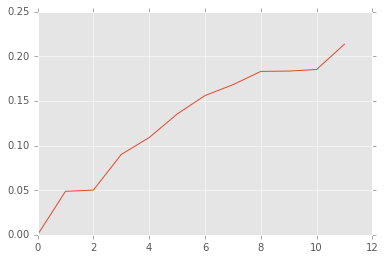

In [13]:
plt.plot(eigval)

In [14]:
e1 = eigvec[:,1]
print((e1>=0).sum(), (e1<0).sum())

1723 79583


(2, 81306)


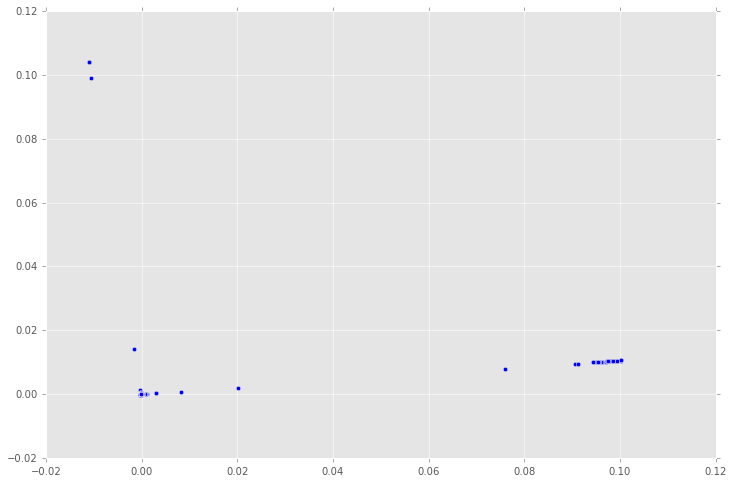

In [15]:
proj = eigvec[:, 1:3].T
print(proj.shape)

pylab.rcParams['figure.figsize'] = (12.0, 8.0)

plt.scatter(proj[0], proj[1])

## kmeans clustering

(81306, 2)
CPU times: user 428 ms, sys: 20 ms, total: 448 ms
Wall time: 114 ms
4
[[-0.00011169 -0.01106782  0.09807468  0.07607216]
 [-0.00012992  0.10417831  0.01030017  0.00796127]]


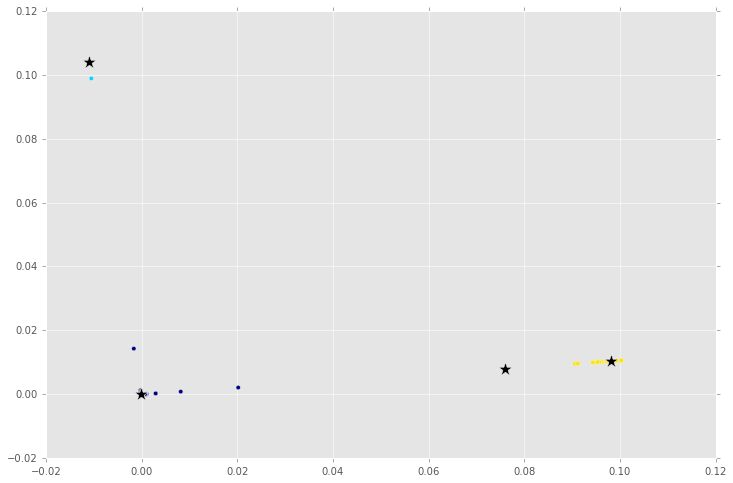

In [16]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

n_clusters = 4

clf = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
#clf = AgglomerativeClustering(n_clusters = n_clusters)
# clf = DBSCAN(eps = 0.005)

print(proj.T.shape)

%time clusters = clf.fit_predict(proj.T)

print(len(np.unique(clusters)))

plt.scatter(proj[0], proj[1], c=clusters)

if "cluster_centers_" in clf.__dict__:
    centers = clf.cluster_centers_.T
    print(centers)
    plt.scatter(centers[0], centers[1], marker='*', s=200, c='black')

### Clustering plus poussé
**Attention:** ici nous normalisons les vecteurs propres.
Cela fait deux différences avec l'algorithme standard de spectral clustering
- normalisation vecteurs propres vs pas normalisation => je retire la normalisation
- 2^k-means sur k vecteurs propres contre k-means sur k vecteurs => je diminue le nombre de clusters

In [17]:
print(eigvec.min(axis=0), eigvec.max(axis=0), eigvec.mean(axis=0))
print(1/(eigvec.max(axis=0) - eigvec.min(axis=0)))

[ 0.00348853 -0.01107709 -0.00038694 -0.09664353 -0.08096127 -0.00064347
 -0.07495229 -0.16103163 -0.03735074 -0.04098563 -0.12456457 -0.1076628 ] [ 0.00352342  0.10030194  0.10423686  0.00039867  0.00089343  0.17268717
  0.00286113  0.00133372  0.07937389  0.14963666  0.00261943  0.01189978] [  3.50707979e-03   1.66050825e-07   1.16403749e-08  -2.95510745e-07
  -6.83821554e-07  -1.69534484e-08  -1.73607347e-07  -1.29998639e-07
  -1.82719106e-07   1.80530094e-07   4.67139841e-07   3.78603062e-07]
[  2.86606289e+04   8.97835159e+00   9.55805397e+00   1.03047953e+01
   1.22167692e+01   5.76932049e+00   1.28512526e+01   6.15894985e+00
   8.56717205e+00   5.24597645e+00   7.86262417e+00   8.36382103e+00]


In [18]:
eigvec_n = (eigvec-eigvec.min(axis=0)) / (eigvec.max(axis=0) - eigvec.min(axis=0))
print(eigvec_n.shape, eigvec.shape)
print(eigvec_n.mean(axis=0))

(81306, 12) (81306, 12)
[ 0.53176141  0.09945546  0.00369854  0.99588877  0.98907685  0.00371228
  0.96322864  0.99178487  0.3199887   0.21501061  0.97940803  0.9004755 ]


n_clusters = 813
(81306, 11)


/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, us

CPU times: user 288 ms, sys: 40 ms, total: 328 ms
Wall time: 1min 35s
813


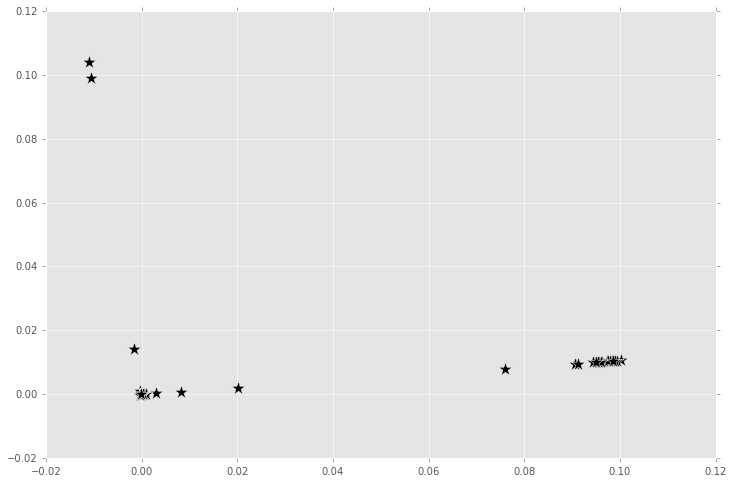

In [19]:
#n_clusters = int(v/40)
n_clusters = int(v/100)
print("n_clusters = %d" % n_clusters)

clf = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, n_jobs=4)
#clf = AgglomerativeClustering(n_clusters = n_clusters)
#clf = DBSCAN(eps = 0.0005)

#X = eigvec_n[:,1:]
X = eigvec[:,1:]

print(X.shape)
%time clusters = clf.fit_predict(X)
print(len(np.unique(clusters)))

plt.scatter(X[:,0], X[:,1], c=clusters)

if "cluster_centers_" in clf.__dict__:
    centers = clf.cluster_centers_.T
    # print(centers)
    plt.scatter(centers[0], centers[1], marker='*', s=200, c='black')

## display clustered graphs

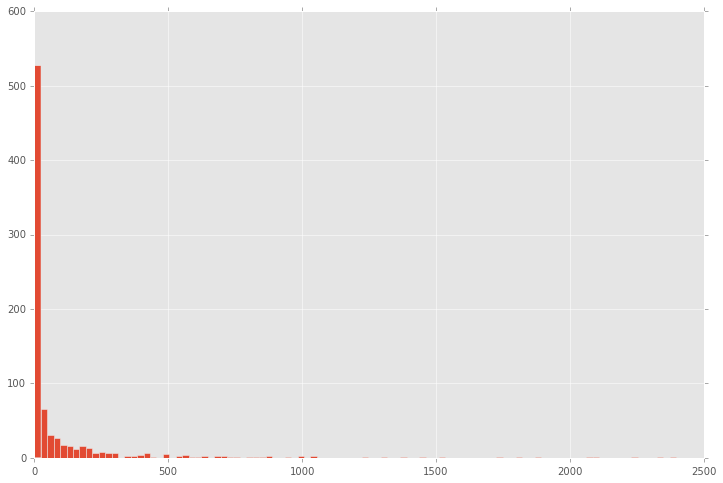

In [20]:
vc = pd.Series(clusters).value_counts()
vc.hist(bins=100)

Un paradoxe: je réduis le nombre de clusters et j'ai plus de clusters de taille 1...

In [21]:
pd.DataFrame({'cnt': vc}).groupby(["cnt"]).size()

cnt
1       166
2        77
3        50
4        35
5        33
6        24
7        19
8        11
9        16
10       11
11       12
12        3
13        6
14        8
15        5
16        6
17        8
18        6
19       10
20        6
21        5
22        2
23        1
24        7
25        4
26        3
27        4
28        4
29        4
30        2
       ... 
673       1
690       1
707       1
709       1
715       1
733       1
752       1
810       1
839       1
855       1
874       1
876       1
949       1
997       1
1003      1
1039      1
1043      1
1244      1
1297      1
1376      1
1438      1
1513      1
1740      1
1801      1
1882      1
2069      1
2100      1
2232      1
2334      1
2396      1
dtype: int64

In [22]:
import networkx as nx

%time g = nx.Graph(list(df.to_records(index=False)))
g

CPU times: user 26 s, sys: 292 ms, total: 26.3 s
Wall time: 26.3 s


Cluster #62 is of size 174
pseudo-degree of cluster is 174


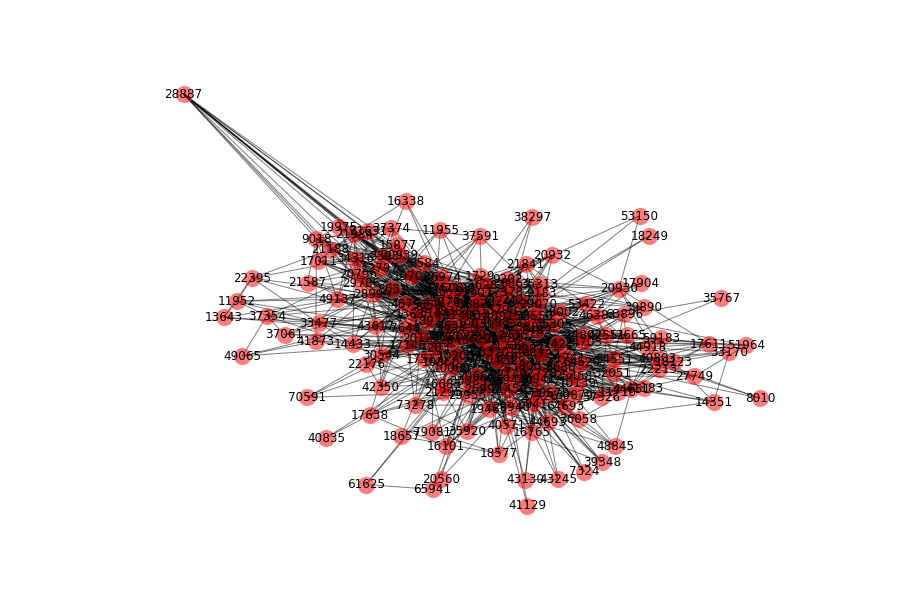

In [23]:
from IPython.html.widgets import interact
import gmet
import graph_helpers

@interact
def plot(cl = ('5', '6', '7', '8', '10', '20', '30', '27', '215', '42', '1150', '449', '62'), 
         degree=("0", "1", "2"), layout=("spring", "std", "spectral")):
    cl = int(cl)
    print("Cluster #%d is of size %d" % (cl, (clusters == cl).sum()))
    
    print("pseudo-degree of cluster is %d" % gmet.group_edge_degree(facebook2, clusters == cl))
    
    graph_helpers.plot_subgraph_links(facebook2, clusters == cl, int(degree), layout=layout, graph=g)

In [24]:
n = 73635

print((clusters[n]), (clusters == clusters[n]).sum())
print((df["0"] == n).sum())
print((df["1"] == n).sum())
df[(df["1"] == n) | (df["0"] == n)]

165 1
81
7


,0,1
1933521,73635,14282
1934780,73635,67693
1935100,42764,73635
1935263,67693,73635
1935400,14282,73635
2136344,48745,73635
2136968,73635,48745
2137634,73635,28774
2137936,62869,73635
2138123,73635,62869


In [25]:
df.head()

,0,1
0,64848,33444
1,15266,30189
2,76829,19302
3,65515,58679
4,52420,16766


CPU times: user 37 s, sys: 0 ns, total: 37 s
Wall time: 37 s
count      813.000000
mean       427.806888
std       1259.978184
min          1.000000
25%          9.000000
50%         41.000000
75%        199.000000
max      11270.000000
dtype: float64


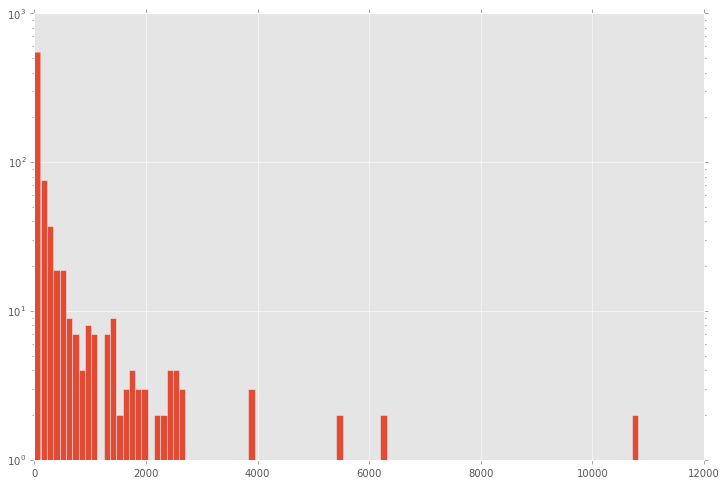

In [26]:
from gmet import group_vertex_degree, group_edge_degree

%time all_degs = [group_vertex_degree(facebook2, clusters == i) for i in range(n_clusters)]

print(pd.Series(all_degs).describe())
_ = plt.hist(all_degs, bins=100)
plt.yscale("log")

### Optimisation à faire
Il faudrait optimiser le calcul des deux "degrés" en le faisant en masse par un big produit matriciel

### Compléments à faire
- implémenter d'autres métriques (cf littérature) comme le RatioCut = sigma cuts / taille et Ncut = sigma cuts / vol
- remettre en non normalisé!
- diminuer le k du k-means

In [27]:
from gmet import group_vertex_degree, group_edge_degree

%time metrics = pd.DataFrame({'sz': [(clusters == cl).sum() for cl in range(n_clusters)], \
                          'vdeg': [group_vertex_degree(facebook2, clusters == i) for i in range(n_clusters)], \
                          'edeg': [group_edge_degree(facebook2, clusters == i) for i in range(n_clusters)]})

metrics["vratio"] = metrics.vdeg / metrics.sz
metrics["eratio"] = metrics.edeg / metrics.sz

metrics.describe()

CPU times: user 1min 15s, sys: 4 ms, total: 1min 15s
Wall time: 1min 15s


,edeg,sz,vdeg,vratio,eratio
count,813.000000,813.000000,813.000000,813.000000,813.000000
mean,1454.103321,100.007380,427.806888,8.449642,12.961859
std,5700.719182,272.565335,1259.978184,13.994278,16.056136
min,2.000000,1.000000,1.000000,0.011111,0.548387
25%,15.000000,2.000000,9.000000,2.083333,3.800000
50%,76.000000,8.000000,41.000000,4.927485,8.000000
75%,438.000000,59.000000,199.000000,9.301887,16.387097
max,77799.000000,2396.000000,11270.000000,219.000000,219.500000


In [28]:
metrics[metrics.vratio < 0.5].describe()

,edeg,sz,vdeg,vratio,eratio
count,56.000000,56.000000,56.000000,56.000000,56.000000
mean,77.017857,62.375000,16.821429,0.215042,1.194608
std,114.282662,77.933903,31.953436,0.126339,0.335897
min,3.000000,3.000000,1.000000,0.011111,0.548387
25%,18.500000,15.500000,1.000000,0.108333,1.000000
50%,35.500000,32.000000,4.000000,0.200000,1.082482
75%,88.500000,76.750000,14.000000,0.314103,1.345853
max,733.000000,433.000000,199.000000,0.467836,2.214286


In [29]:
metrics[metrics.vratio < 0.5][metrics.vdeg < 10].describe()

/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,edeg,sz,vdeg,vratio,eratio
count,36.000000,36.000000,36.000000,36.000000,36.000000
mean,24.027778,21.833333,2.805556,0.177134,1.159293
std,18.147784,17.693421,2.400231,0.115923,0.300279
min,3.000000,3.000000,1.000000,0.011111,0.548387
25%,10.000000,9.000000,1.000000,0.076389,1.000000
50%,20.000000,20.000000,2.000000,0.173950,1.051151
75%,33.500000,31.000000,3.000000,0.261730,1.229167
max,90.000000,90.000000,9.000000,0.400000,2.000000


In [30]:
metrics[metrics.eratio < 1].describe()

,edeg,sz,vdeg,vratio,eratio
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,104.142857,126.285714,35.571429,0.277959,0.812219
std,61.371624,75.267776,28.849362,0.117165,0.133454
min,17.000000,31.000000,8.000000,0.120773,0.548387
25%,65.500000,71.000000,16.000000,0.217268,0.783922
50%,88.000000,101.000000,25.000000,0.259259,0.850242
75%,158.000000,198.000000,46.500000,0.347752,0.881590
max,177.000000,214.000000,91.000000,0.435644,0.955882


In [31]:
from imp import reload
import gmet
reload(gmet)

metrics["ratio_cut"] = gmet.ratio_cut_list(facebook2, clusters)
metrics["n_cut"] = gmet.n_cut_list(facebook2, clusters)

metrics.describe()

,edeg,sz,vdeg,vratio,eratio,ratio_cut,n_cut
count,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000
mean,1454.103321,100.007380,427.806888,8.449642,12.961859,12.961859,0.806338
std,5700.719182,272.565335,1259.978184,13.994278,16.056136,16.056136,0.262884
min,2.000000,1.000000,1.000000,0.011111,0.548387,0.548387,0.011918
25%,15.000000,2.000000,9.000000,2.083333,3.800000,3.800000,0.703704
50%,76.000000,8.000000,41.000000,4.927485,8.000000,8.000000,0.931034
75%,438.000000,59.000000,199.000000,9.301887,16.387097,16.387097,1.000000
max,77799.000000,2396.000000,11270.000000,219.000000,219.500000,219.500000,1.000000


Même avec une centaine de vertex par sous-graphe en moyenne, on a la moitié des sous-graphes à moins de 8 composantes => OK pour diminuer le nombre de clusters!

In [32]:
metrics[metrics.sz >= 4].describe()

,edeg,sz,vdeg,vratio,eratio,ratio_cut,n_cut
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,2260.663462,155.453846,657.626923,6.159088,12.600304,12.600304,0.706290
std,7002.530345,328.155354,1528.436984,7.644997,12.085287,12.085287,0.281022
min,5.000000,4.000000,1.000000,0.011111,0.548387,0.548387,0.011918
25%,76.750000,9.000000,35.750000,1.500000,3.669638,3.669638,0.528596
50%,229.500000,31.000000,111.000000,4.049404,9.060876,9.060876,0.805084
75%,1121.250000,149.000000,459.250000,7.696635,17.903153,17.903153,0.939569
max,77799.000000,2396.000000,11270.000000,65.789474,87.000000,87.000000,1.000000


In [33]:
metrics[(metrics.sz >=4) & (metrics.n_cut < 0.2) & (metrics.ratio_cut < 2)]

,edeg,sz,vdeg,vratio,eratio,ratio_cut,n_cut
1,90.0,90,1,0.011111,1.000000,1.000000,0.153061
62,174.0,174,28,0.160920,1.000000,1.000000,0.046574
143,140.0,189,49,0.259259,0.740741,0.740741,0.022343
169,88.0,101,44,0.435644,0.871287,0.871287,0.041865
210,176.0,207,25,0.120773,0.850242,0.850242,0.033145
268,269.0,198,113,0.570707,1.358586,1.358586,0.030495
281,303.0,200,103,0.515000,1.515000,1.515000,0.075429
292,66.0,74,20,0.270270,0.891892,0.891892,0.052885
296,17.0,31,8,0.258065,0.548387,0.548387,0.068273
311,177.0,214,91,0.425234,0.827103,0.827103,0.036745


In [34]:
metrics[(metrics.sz >= 4) & (metrics.vratio < 0.15)]

,edeg,sz,vdeg,vratio,eratio,ratio_cut,n_cut
1,90.0,90,1,0.011111,1.000000,1.000000,0.153061
7,33.0,33,1,0.030303,1.000000,1.000000,0.272727
16,57.0,57,1,0.017544,1.000000,1.000000,0.826087
28,27.0,27,1,0.037037,1.000000,1.000000,0.675000
42,20.0,20,1,0.050000,1.000000,1.000000,0.666667
50,8.0,8,1,0.125000,1.000000,1.000000,1.000000
58,19.0,19,1,0.052632,1.000000,1.000000,0.422222
94,20.0,20,1,0.050000,1.000000,1.000000,0.909091
210,176.0,207,25,0.120773,0.850242,0.850242,0.033145
273,9.0,9,1,0.111111,1.000000,1.000000,1.000000


In [35]:
print(metrics.ratio_cut.sum(), metrics.n_cut.sum())

10537.991562449628 655.5525603385285
